In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tweepy
import json
import tweetnlp
import openai

2023-11-27 11:40:36,463	INFO util.py:159 -- Outdated packages:
  ipywidgets==7.6.5 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-11-27 11:40:36,777	INFO util.py:159 -- Outdated packages:
  ipywidgets==7.6.5 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
# import functions

import sys
sys.path.append('../Functions/')  # Adjust the relative path as needed

# from json_transform import get_all_keys, flatten_json

### **Load and Transform the Data**

In [4]:
''' 
The JSON data is nested, so we need to flatten it to be able to convert it to a DataFrame.
We will use the get_all_keys() and flatten_json() functions from the json_transform.py file.
After getting all the keys, we will convert them to a list and then flatten the JSON data.
Convert the flattened data to a DataFrame and filter out the rows that contain "update" in the text column.
'''
all_tweets = pd.read_csv("../../Data/Processed/Sprint6 - survey_irony - Ecem.csv")

In [7]:
all_tweets.head(5)

,Timestamp,What is your name?,@TLRailUK why don't the doors open at every station to save us folk having to touch the button?!,@TLRailUK When on phone to @LNER they said as it was cancelled they've also cancelled ticket and issued refund so now no ticket. That shows on time but all trains going via Croydon before reaching Stevenage so looks like all will be delayed/cancelled,"@LiveCommute @bus131 @tlupdates @TLRailUK @brighton_line They are monopolies which go unregulated regarding genuine customer experience, hence three hour train journeys without tables, trays, heating, luggage racks even though they service two of Europes busiest airports. It's a failed industry.",@TLRailUK what is going on with the 17:11 from BFR to PLU? We've been on the train for the best part of an hour and are still stuck outside Deptford? Delay repay? Will it ever get to PLU?,"@NetworkRailSE @SouthernRailUK #TLUpdates - Thameslink services may be subject to further delay on between London & Bedford and London & Cambridge as a knock on effect of this issue. Full details, including service updates, live departures & ticket acceptance â„¹ï¸�ðŸ‘‡ https://t.co/iYMraBkjSy","@ClaireTierney5 The 1611 was diverted between East Croydon and Blackfriars not calling at London Bridge, but Thameslink didn't bother to update the data so Customer Information Screens and Journey Planers didn't show the alteration.",@soran1 @TLRailUK Drivers are not in charge of heating or AC on class 700 trains. It's set by the owner-maker at their depots,@TLRailUK I hear the managers are staying at the St pancras hotel because of concerns of their trains being cancelled or delayed making them late ðŸ˜‚ðŸ˜‚ðŸ˜‚,...,@TLRailUK why are trains cancelled or delayed from Bedford? Nothing on your twitter feed about any problems?,Unnamed: 97,1606 LNER train to Newark North Gate: Delayed 1627 Grand Central train to Bradford Interchange: On time - plat 10 1628 Thameslink train to Cambridge: On time 1633 LNER train to Leeds: On time - plat 1 1630 LNER train to Edinburgh: expected 1635,@TLRailUK @SouthernRailUK Carried on to East Croydon where I'm waiting for service to st pancras,1949 Thameslink train to Brighton: Delayed - plat 1 1840 EMR train to Nottingham: expected 2002 - plat 4 2005 Thameslink train to Gatwick Airport: Delayed - plat 3 1940 EMR train to Nottingham: expected 2008 - plat 4,1012 Thameslink train to Cambridge: Delayed - plat 7 1038 Great Northern train to Moorgate: On time - plat 1 1039 Great Northern train to Hertford North: Cancelled 1022 Thameslink train to Brighton: expected 1042 - plat 2 1043 Great Northern train to Moorgate: Cancelled,TRAVEL: 15 minute delays on @SouthernRailUK @TLRailUK at #Redhill due to a points failure,@TLRailUK What's happening?? Driver hasn't given an announcement in 20 mins - doors are locked and meanwhile trains are going past we could get on,Evening @tlrailuk - you cancel the 1724 ZFD to HHE due to no staff and the 1724 following service is overcrowded with no guard (we had one this morning) to tell that air con is broken - carriage 412114 - rear carriage going south.,@TLRailUK You opened the doors 20 seconds after a train on the parallel platform pulled away. That is absolutely terrible service.
0,2023/11/25 12:52:01 PM GMT+1,Erjon,"No, it is not ironic","No, it is not ironic","No, it is not ironic","No, it is not ironic","No, it is not ironic","No, it is not ironic","No, it is not ironic","No, it is not ironic",...,"No, it is not ironic",NaN,"No, it is not ironic","No, it is not ironic","No, it is not ironic","No, it is not ironic","No, it is not ironic","No, it is not ironic","No, it is not ironic","No, it is not ironic"
1,2023/11/25 1:54:46 PM GMT+1,Ecem,"No, it is not ironic","No, it is not ironic","No, it is not ironic","No, it is not ironic","No, it is not ironic","No, it is not ironic","No, it is not ironic","No, it is not ironic",...,"No, it is not ironic",I am trying my best.,"No, it is not ironic","No, it is not ironic","No, it is not 

In [8]:
# Assuming survey_irony is your DataFrame
string_to_find = 'I am trying my best'

# Check if the string is present in any cell of the DataFrame
columns_with_string = all_tweets.applymap(lambda x: string_to_find in str(x)).any()

# Get the column indices where the string is present
indices_with_string = columns_with_string[columns_with_string].index

# Display the column indices
print("Column indices with the string:", indices_with_string)

#Show related column
all_tweets[indices_with_string]

#Drop the column
all_tweets.drop(columns=indices_with_string, inplace=True)

Column indices with the string: Index(['Unnamed: 97'], dtype='object')


In [9]:
# Assuming survey_irony is your DataFrame
string_to_find = 't even realize I was halfway through. very fun'

# Check if the string is present in any cell of the DataFrame
columns_with_string = all_tweets.applymap(lambda x: string_to_find in str(x)).any()

# Get the column indices where the string is present
indices_with_string = columns_with_string[columns_with_string].index

# Display the column indices
print("Column indices with the string:", indices_with_string)

#Show related column
all_tweets[indices_with_string]

#Drop the column
all_tweets.drop(columns=indices_with_string, inplace=True)

Column indices with the string: Index(['Unnamed: 53'], dtype='object')


In [10]:
# Creating a new DataFrame with the required columns
new_columns = ["text", "irony number", "not irony number",
               "Erjon", "Ecem", "Cem", "Akshay", "Shinu"]
all_tweets_edited = pd.DataFrame(columns=new_columns)

#Move intex to the text column
all_tweets_edited.set_index("text", inplace=True)

#Copy the 1st row of the survey_irony to the new DataFrame's Erjon column
all_tweets_edited["Erjon"] = all_tweets.iloc[0, 1:]

#Copy the 2nd row of the survey_irony to the new DataFrame's Ecem column
all_tweets_edited["Ecem"] = all_tweets.iloc[1, 1:]

#Copy the 3rd row of the survey_irony to the new DataFrame's Cem column
all_tweets_edited["Cem"] = all_tweets.iloc[2, 1:]

#Copy the 4th row of the survey_irony to the new DataFrame's Akshay column
all_tweets_edited["Akshay"] = all_tweets.iloc[3, 1:]

#Copy the 5th row of the survey_irony to the new DataFrame's Shinu column
all_tweets_edited["Shinu"] = all_tweets.iloc[4, 1:]

#Delete What is your name? row
all_tweets_edited.drop("What is your name?", inplace=True)

all_tweets_edited = all_tweets_edited.reset_index()

print(all_tweets_edited.shape)
all_tweets_edited.head(1)

(102, 8)


,text,irony number,not irony number,Erjon,Ecem,Cem,Akshay,Shinu
0,@TLRailUK why don't the doors open at every st...,NaN,NaN,"No, it is not ironic","No, it is not ironic","No, it is not ironic","No, it is not ironic","No, it is not ironic"


In [11]:
#Create a copy of the DataFrame named survey_edited
survey_edited = all_tweets_edited.copy()

In [13]:

survey_edited['not irony number'] = survey_edited.apply(lambda row: row.str.count('No, it is not ironic').sum(), axis=1)
survey_edited['irony number'] = survey_edited.apply(lambda row: row.str.count('Yes, it is ironic').sum(), axis=1)

survey_edited['irony number'] = survey_edited['irony number'].astype(str).str[:-2].astype(int)
survey_edited['not irony number'] = survey_edited['not irony number'].astype(str).str[:-2].astype(int)

#Create a pattern column that combines numbers in the irony and not irony columns
survey_edited['pattern'] = survey_edited['irony number'].astype(str) + survey_edited['not irony number'].astype(str)

# Display the modified DataFrame
survey_edited.head(1)

,text,irony number,not irony number,Erjon,Ecem,Cem,Akshay,Shinu,pattern
0,@TLRailUK why don't the doors open at every st...,0,5,"No, it is not ironic","No, it is not ironic","No, it is not ironic","No, it is not ironic","No, it is not ironic",05


In [15]:
all_tweets_edited.head(1)

,text,irony number,not irony number,Erjon,Ecem,Cem,Akshay,Shinu
0,@TLRailUK why don't the doors open at every st...,NaN,NaN,"No, it is not ironic","No, it is not ironic","No, it is not ironic","No, it is not ironic","No, it is not ironic"


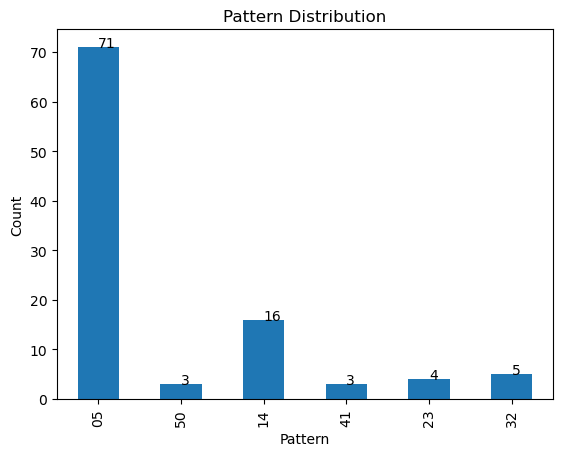

In [14]:
# Reorder the index of the value counts based on your desired sequence
desired_sequence = ['05', '50', '14', '41', '23', '32']
survey_edited_ordered = survey_edited.set_index('pattern').loc[desired_sequence].reset_index()

# Create a bar chart showing the distribution of the pattern column
ordered_value_counts = survey_edited_ordered['pattern'].value_counts()
ordered_value_counts = ordered_value_counts.reindex(desired_sequence)  # Reorder the index
ordered_value_counts.plot(kind='bar')

# Add quantities on top of each bar
for index, value in enumerate(ordered_value_counts):
    plt.text(index, value, str(value))

# Add title and axis names
plt.title('Pattern Distribution')
plt.ylabel('Count')
plt.xlabel('Pattern')
plt.show()

In [19]:
# Print the pattern distribution
print('The number of tweets in which we all agree is an irony: ', survey_edited['pattern'].value_counts().get('50', 0))
print('The number of tweets in which we all agree is not an irony: ', survey_edited['pattern'].value_counts().get('05', 0))
print('The number of tweets in which it\'s 4 votes for an irony: ', survey_edited['pattern'].value_counts().get('41', 0))
print('The number of tweets in which it\'s 4 votes for not an irony: ', survey_edited['pattern'].value_counts().get('14', 0))
print("The number of tweets where there is no agreement: ", survey_edited['pattern'].value_counts().get('32', 0))
print("Also the number of tweets where there is no agreement: ", survey_edited['pattern'].value_counts().get('23', 0))



The number of tweets in which we all agree is an irony:  3
The number of tweets in which we all agree is not an irony:  71
The number of tweets in which it's 4 votes for an irony:  3
The number of tweets in which it's 4 votes for not an irony:  16
The number of tweets where there is no agreement:  5
Also the number of tweets where there is no agreement:  4


In [21]:
#Create a column with the name of control that contains True False column where pattern is 50, 41, 14, 05 is True and 23, 32 is False
survey_edited['control'] = survey_edited['pattern'].isin(['50', '41'])
survey_edited.head(15)

,text,irony number,not irony number,Erjon,Ecem,Cem,Akshay,Shinu,pattern,control
0,@TLRailUK why don't the doors open at every st...,0,5,"No, it is not ironic","No, it is not ironic","No, it is not ironic","No, it is not ironic","No, it is not ironic",05,False
1,@TLRailUK When on phone to @LNER they said as ...,0,5,"No, it is not ironic","No, it is not ironic","No, it is not ironic","No, it is not ironic","No, it is not ironic",05,False
2,@LiveCommute @bus131 @tlupdates @TLRailUK @bri...,0,5,"No, it is not ironic","No, it is not ironic","No, it is not ironic","No, it is not ironic","No, it is not ironic",05,False
3,@TLRailUK what is going on with the 17:11 from...,0,5,"No, it is not ironic","No, it is not ironic","No, it is not ironic","No, it is not ironic","No, it is not ironic",05,False
4,@NetworkRailSE @SouthernRailUK #TLUpdates - Th...,0,5,"No, it is not ironic","No, it is not ironic","No, it is not ironic","No, it is not ironic","No, it is not ironic",05,False
5,@ClaireTierney5 The 1611 was diverted between ...,0,5,"No, it is not ironic","No, it is not ironic","No, it is not ironic","No, it is not ironic","No, it is not ironic",05,False
6,@soran1 @TLRailUK Drivers are not in charge of...,1,4,"No, it is not ironic","No, it is not ironic","No, it is not ironic","No, it is not ironic","Yes, it is ironic",14,False
7,@TLRailUK I hear the managers are staying at t...,1,4,"No, it is not ironic","No, it is not ironic","No, it is not ironic","No, it is not ironic","Yes, it is ironic",14,False
8,Hi @TLRailUK your 2008 Horsham to Peterborough...,1,4,"No, it is not ironic","No, it is not ironic","No, it is not ironic","No, it is not ironic","Yes, it is ironic",14,False
9,@geofftech stuck on heavily delayed Thameslink...,5,0,"Yes, it is ironic","Yes, it is ironic","Yes, it is ironic","Yes, it is ironic","Yes, it is ironic",50,True


In [26]:
# filter out the rows that contain "update" in the text column of all_tweets_edited
all_tweets_edited = all_tweets_edited[~all_tweets_edited['text'].str.contains("update")]
number_total_tweets = len(all_tweets_edited)

#Printing tweet length after filtering out the rows that contain "update" in the text column
print("Number of total tweets after filtering out the rows that contain 'update' in the text column of modelling dataset: ", number_total_tweets)

Number of total tweets after filtering out the rows that contain 'update' in the text column of modelling dataset:  95


In [27]:
# filter out the rows that contain "update" in the text column of survey_edited
survey_edited = survey_edited[~survey_edited['text'].str.contains("update")]
number_total_tweets = len(survey_edited)

#Printing tweet length after filtering out the rows that contain "update" in the text column
print("Number of total tweets after filtering out the rows that contain 'update' in the text column of survey dataset: ", number_total_tweets)

Number of total tweets after filtering out the rows that contain 'update' in the text column of survey dataset:  95


In [28]:
# filter duplicated rows of all_tweets_edited
all_tweets_edited = all_tweets_edited.drop_duplicates(subset=['text'])
number_total_tweets = len(all_tweets_edited)

#Printing tweet length after filtering out the duplicated rows
print("Number of total tweets after filtering out the duplicated rows of modelling dataset: ", number_total_tweets)

# filter duplicated rows of survey_edited
survey_edited = survey_edited.drop_duplicates(subset=['text'])
number_total_tweets = len(survey_edited)

#Printing tweet length after filtering out the duplicated rows
print("Number of total tweets after filtering out the duplicated rows of survey dataset: ", number_total_tweets)

Number of total tweets after filtering out the duplicated rows of modelling dataset:  95
Number of total tweets after filtering out the duplicated rows of survey dataset:  95


In [29]:
# filter out the rows that contain "delay" in the text column of all_tweets_edited
all_tweets_edited = all_tweets_edited[~all_tweets_edited['text'].str.contains("delay")]
number_total_tweets = len(all_tweets_edited)

#Printing tweet length after filtering out the rows that contain "delay" in the text column
print("Number of total tweets after filtering out the rows that contain 'delay' in the text column of modelling dataset: ", number_total_tweets)

# filter out the rows that contain "delay" in the text column of survey_edited
survey_edited = survey_edited[~survey_edited['text'].str.contains("delay")]
number_total_tweets = len(survey_edited)

#Printing tweet length after filtering out the rows that contain "delay" in the text column
print("Number of total tweets after filtering out the rows that contain 'delay' in the text column of survey dataset: ", number_total_tweets)

Number of total tweets after filtering out the rows that contain 'delay' in the text column of modelling dataset:  56
Number of total tweets after filtering out the rows that contain 'delay' in the text column of survey dataset:  56


In [30]:
#Check for irony in the all_tweets_edited dataset using the tweetnlp library and save the results in a new column called irony
model_irony = tweetnlp.load_model('irony')
#Create a new dataframe called transformed_tweets_irony as a copy of all_tweets_edited
transformed_tweets_irony = all_tweets_edited.copy()

transformed_tweets_irony['irony'] = transformed_tweets_irony['text'].apply(lambda x: model_irony.predict(x)['label'])

irony_counts = transformed_tweets_irony['irony'].value_counts()
number_irony_tweets = irony_counts.loc['irony'] if 'irony' in irony_counts else 0

print(f'Number of ironic tweets depending on the model: {number_irony_tweets}')

Number of ironic tweets depending on the model: 11


In [31]:
#Print text column of transformed_tweets_irony dataframe where irony is ironic
transformed_tweets_irony[transformed_tweets_irony['irony'] == 'irony']['text']

22     @TLRailUK 0930 at ECR (on late 0807 BTN to LBG...
33     @TLRailUK it seems remarkable that the train i...
34     @TLRailUK it seems remarkable that the train i...
46     for nothing! @TLRailUK No paper in the toilet ...
53     Delightful @TLRailUK train this morning - fill...
54     Oh great, looks like @TLRailUK on-train WiFi d...
69     Govia Thameslink fined Â£1m over Gatwick Expre...
81     The seats on @TLRailUK are made to give you ba...
84     Commuting public: "hurrah, the school holidays...
89     Taking the Biscuit?! Sweet treat apology from ...
101    @TLRailUK You opened the doors 20 seconds afte...
Name: text, dtype: object

In [33]:
# find the total number of ironies in survey_edited dataset regarding pattern column is 50 and 41
number_irony_tweets = len(survey_edited[(survey_edited['pattern'] == '50') | (survey_edited['pattern'] == '41')])
print(f'Number of ironic tweets depending on the survey: {number_irony_tweets}')

Number of ironic tweets depending on the survey: 2


In [34]:
#Print text column of survey_edited dataframe where irony is ironic
survey_edited[survey_edited['pattern'].isin(['50', '41'])]['text']

73    @NetworkRailSE @Se_Railway @SouthernRailUK @TL...
84    Commuting public: "hurrah, the school holidays...
Name: text, dtype: object

In [35]:
#Show the tweets that are ironic for both model and survey
irony_tweets = survey_edited[(survey_edited['pattern'] == '50') | (survey_edited['pattern'] == '41')]
irony_tweets

,text,irony number,not irony number,Erjon,Ecem,Cem,Akshay,Shinu,pattern,control
73,@NetworkRailSE @Se_Railway @SouthernRailUK @TL...,4,1,"Yes, it is ironic","Yes, it is ironic","Yes, it is ironic","No, it is not ironic","Yes, it is ironic",41,True
84,"Commuting public: ""hurrah, the school holidays...",5,0,"Yes, it is ironic","Yes, it is ironic","Yes, it is ironic","Yes, it is ironic","Yes, it is ironic",50,True
